### Import libraries

In [1]:
import sys
sys.path.append("..")
import os
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader, data_generation
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import itertools

In [3]:
kernel = "monthly_global_avg_climate"
d = True

In [4]:
mpi = np.load('/Users/omernivron/Downloads/MPI_ESM_monthly_global_mean.npy')
gfdl = np.load('/Users/omernivron/Downloads/GFDL_monthly_global_mean.npy')

In [5]:
t = np.load('/Users/omernivron/Downloads/monthly_t.npy')

In [8]:
import xarray 

In [9]:
aa = xarray.open_dataset("/Users/omernivron/saved_on_disk.nc")

In [18]:
bb = aa.to_dataframe().reset_index()

In [9]:
plt.style.use('ggplot')

In [10]:
import pandas as pd

In [47]:
pd.DataFrame.to_csv(bb, 'observed_climate_1981_2014.csv')

In [51]:
pd.DataFrame.to_csv(pd.DataFrame(mpi), 'mpi_center_monthly_avg_1921_2005.csv')

/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


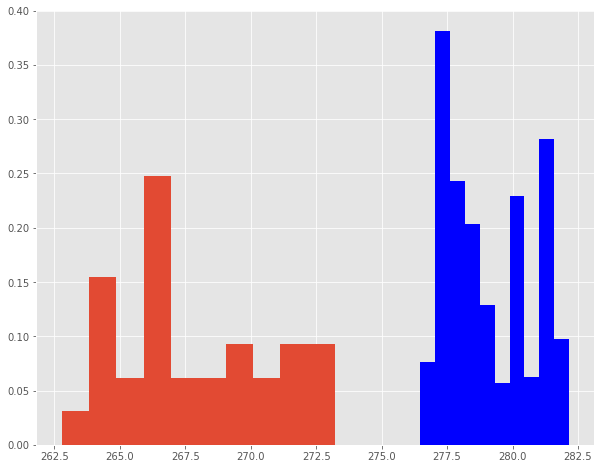

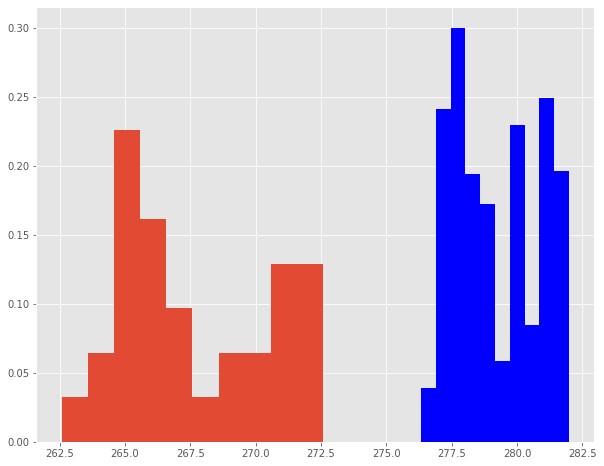

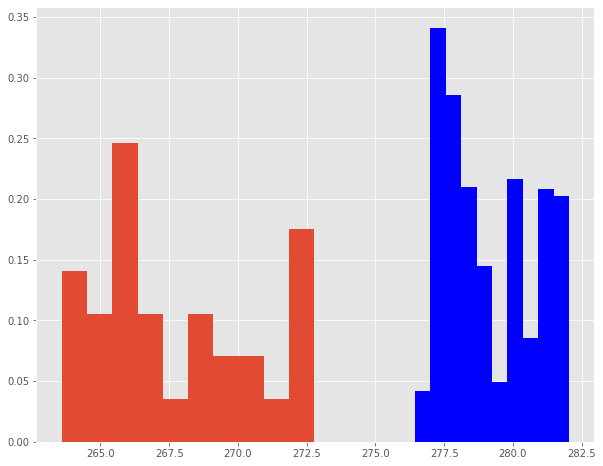

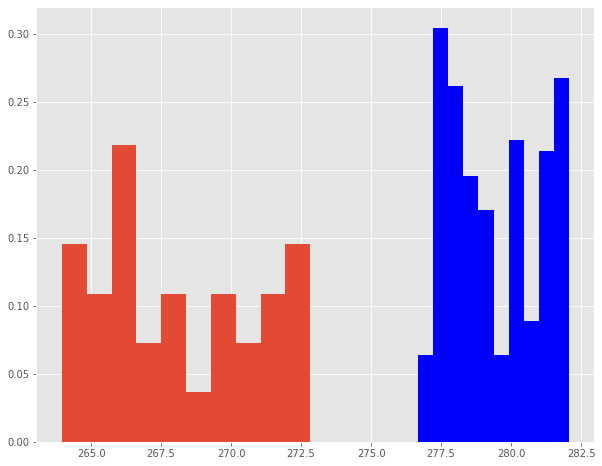

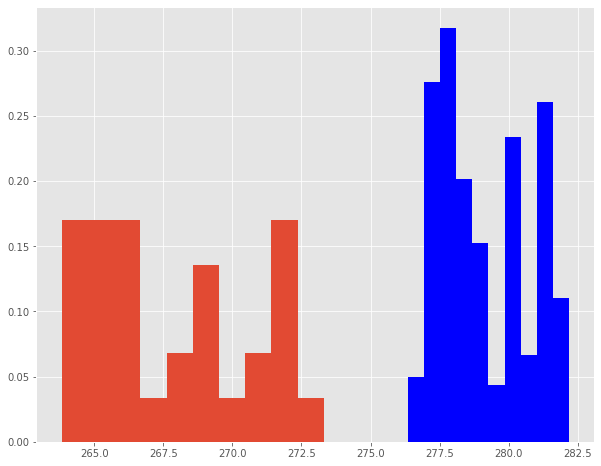

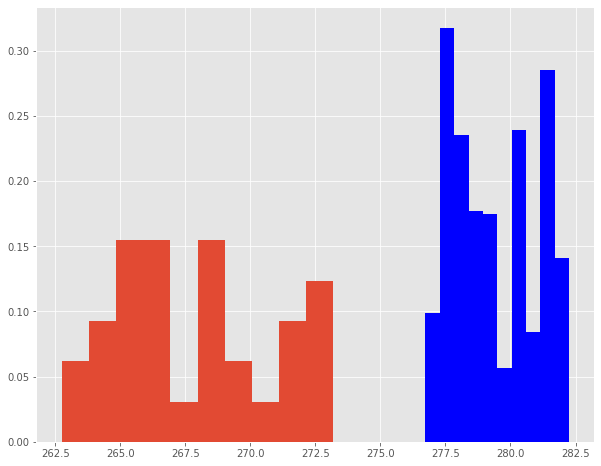

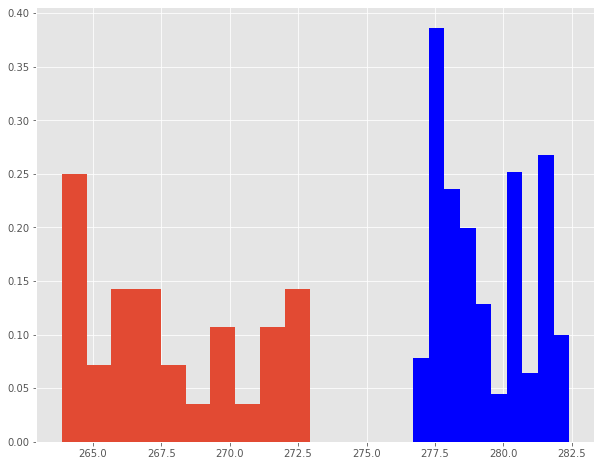

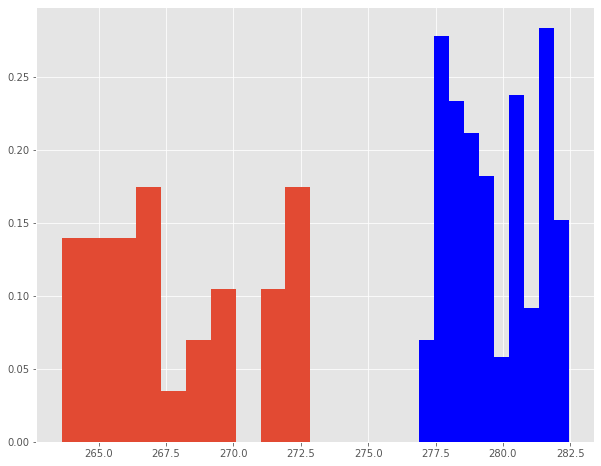

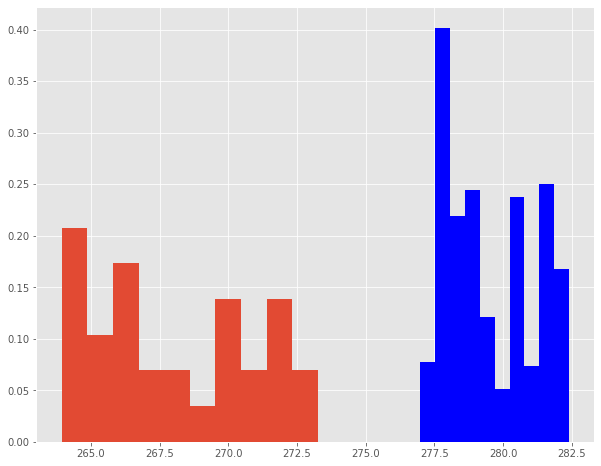

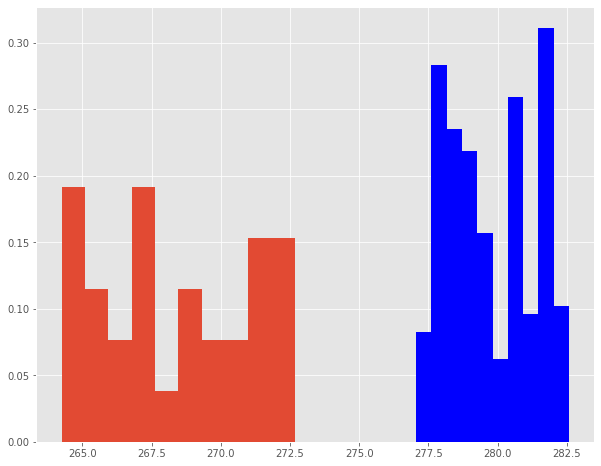

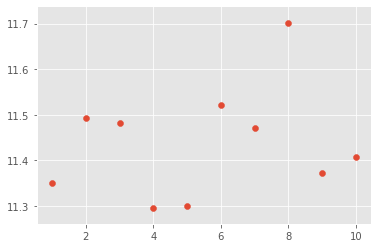

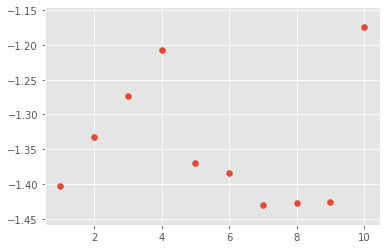

In [43]:
counter = np.arange(1, 11)
m = []
s = [] 
for i in range(720, 1020, 30):
    plt.figure(figsize=(10, 8))
    a = (mpi[:30, i:(i+30)]).reshape(-1)
    b = bb.loc[(i-720):(i-690), 't2m']
    m.append(a.mean() - b.mean())
    s.append(a.std() - b.std())
    plt.hist(a, color= 'blue', normed=True)
    plt.hist(b, normed=True)
    plt.show()
plt.scatter(counter, m)
plt.show()
plt.scatter(counter, s)
plt.show()

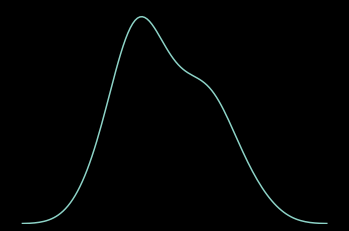

In [47]:
import seaborn as sns
plt.style.use('dark_background')
plt.axis('off')
sns.kdeplot( mpi[:, 1000].reshape(-1))

In [38]:
save_dir = os.path.expanduser('~/Downloads/' + kernel)

In [39]:
data = np.concatenate((mpi, gfdl), axis = 0)
# μ = np.mean(data)
# σ = np.std(data)
# mpi = (mpi - μ) 
# gfdl = (gfdl - μ) 

In [40]:
n = mpi.shape[0]
m = gfdl.shape[0]
seq_len = 1020

In [41]:
combos = list(itertools.combinations(np.arange(n), 2)) + [(i, i) for i in range(n)]
data = [np.concatenate((mpi[pair[0]].reshape(1, -1), gfdl[pair[1]].reshape(1, -1)), axis = 1) if (pair[1] < 30) else np.zeros((1, 2040)) for pair in combos]

In [42]:
df = np.concatenate(data, axis=0)

In [43]:
y = df[~np.all(df == 0, axis=1)]

In [44]:
t = np.concatenate((t, t))
# mean_t = np.mean(t)
# t = t - np.mean(t)

In [45]:
d_y = np.array([np.concatenate((y[i][j:j+205], y[i][1020+j:1225 +j])) for i in range(len(y)) for j in range(0, 815, 163) ])
t_y = np.array([np.concatenate((t[j:j+205], t[1020+j:1225 +j])) for i in range(len(y)) for j in range(0, 815, 163)])

In [46]:
def embed_position(t, d, TΔmin, Tmax):  # return.shape=(T,B,d)
    # t.shape=(T,B)   T=sequence_length, B=batch_size
    """A position-embedder, similar to the Attention paper, but tweaked to account for
    floating point positions, rather than integer.
    """
    R = Tmax / TΔmin * 100
    drange_even = TΔmin * R**(np.arange(0,d,2)/d)
    drange_odd = TΔmin * R**((np.arange(1,d,2) - 1)/d)
    x = np.concatenate([np.sin(t[:,:,None] / drange_even), np.cos(t[:,:,None] / drange_odd)], 2)
    return x

In [47]:
k = np.concatenate([np.zeros(205, dtype=int), np.ones(205, dtype=int)])

In [48]:
x1 = np.array([embed_position(t_y[i, :][:, None], d=94, TΔmin= 0.05, Tmax=30) for i in range(len(t_y))])
x2 = np.repeat(tf.one_hot(k, 2)[None, :, None, :],  2325, axis =0)
x = np.concatenate((x1, x2), axis =-1).squeeze()

In [49]:
d_y.shape

(2325, 410)

In [50]:
x.shape

(2325, 410, 96)

In [51]:
x[:, :, 0].shape

(2325, 410)

(array([ 23179., 130290.,  80944., 101690., 148683., 127678., 133126.,
         86823.,  75603.,  45234.]),
 array([273.62161255, 274.47879028, 275.33596802, 276.19314575,
        277.05032349, 277.90750122, 278.76467896, 279.62185669,
        280.47903442, 281.33621216, 282.19338989]),
 <a list of 10 Patch objects>)

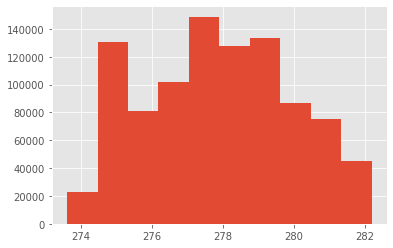

In [52]:
plt.hist(d_y.reshape(-1))

In [53]:
mean_t

NameError: name 'mean_t' is not defined

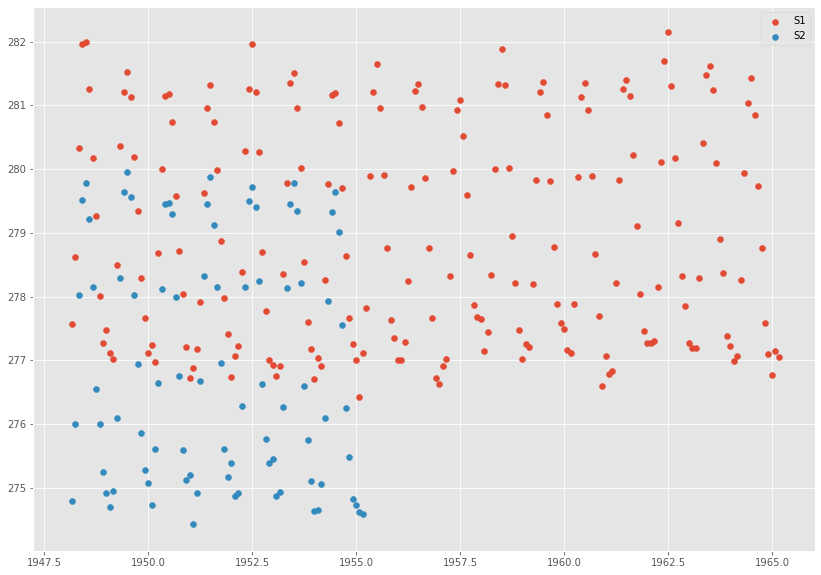

In [54]:
plt.style.use('ggplot')
cmap = plt.get_cmap('Paired', 2)

fig,ax = plt.subplots(figsize=(14, 10))
ax.scatter(t_y[17, :205] , d_y[17][:205], label ='S1')
ax.scatter(t_y[17, 205:290] , d_y[17][205:290], label = 'S2')
leg = plt.legend()
for text in leg.get_texts():
    text.set_color("black")

plt.show()

In [55]:
train_step, test_step, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [56]:
# b_data = batch_creator.create_batch(em_x = data[1], em_y=data[3], x = data[5], y = data[-1], batch_s=2, d=d)
# b_data_te = b_data

In [57]:
# Uncomment the two lines below for one batch to overfit on
# np.random.seed(443)
# b_data, c = batch_creator.create_batch_2d(data[2], data[-3], data[-1], batch_s=20, em_2 = data[3])

### Training

Does not exist
New folder /Users/omernivron/Downloads/monthly_global_avg_climate/ckpt/check_run_7
Initializing from scratch.
2029


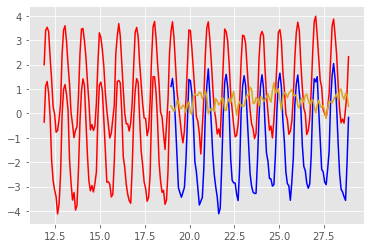

Epoch 0 batch 0 train Loss 16.0537 test Loss 8.6152 with training MSE metric 6.1779 and testing MSE metric 6.0031
learning rate is 0.0003000000142492354
2240


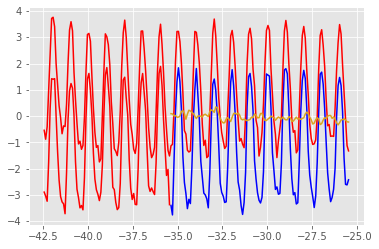

Epoch 0 batch 50 train Loss 0.8446 test Loss 0.8334 with training MSE metric 4.4790 and testing MSE metric 4.3925
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 136.44739890098572 secs

2072


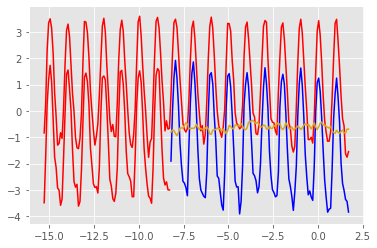

Epoch 1 batch 0 train Loss 0.7740 test Loss 0.7617 with training MSE metric 3.7218 and testing MSE metric 3.6793
learning rate is 0.0003000000142492354
2209


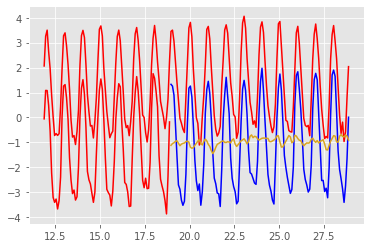

Epoch 1 batch 50 train Loss 0.7525 test Loss 0.7327 with training MSE metric 3.4580 and testing MSE metric 3.3555
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 166.1237030029297 secs

2056


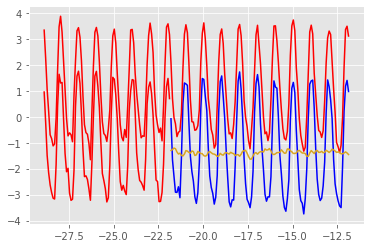

Epoch 2 batch 0 train Loss 0.7395 test Loss 0.7256 with training MSE metric 3.3768 and testing MSE metric 3.2997
learning rate is 0.0003000000142492354
2166


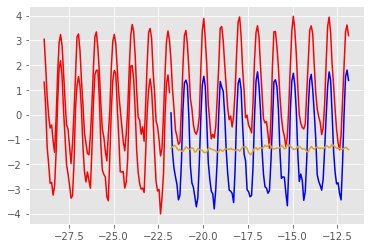

Epoch 2 batch 50 train Loss 0.7297 test Loss 0.7241 with training MSE metric 3.3102 and testing MSE metric 3.3657
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 153.40680599212646 secs

2021


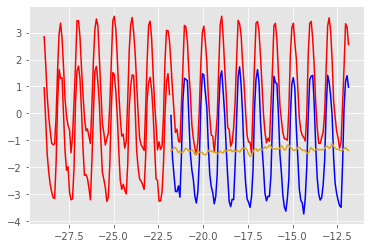

Epoch 3 batch 0 train Loss 0.7248 test Loss 0.7136 with training MSE metric 3.2810 and testing MSE metric 3.2683
learning rate is 0.0003000000142492354
2128


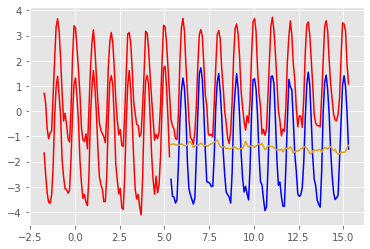

Epoch 3 batch 50 train Loss 0.7220 test Loss 0.7105 with training MSE metric 3.3108 and testing MSE metric 3.2924
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 154.07816195487976 secs

2173


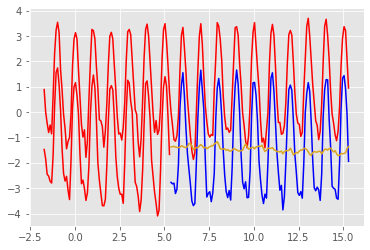

Epoch 4 batch 0 train Loss 0.7111 test Loss 0.7074 with training MSE metric 3.2428 and testing MSE metric 3.2988
learning rate is 0.0003000000142492354
2076


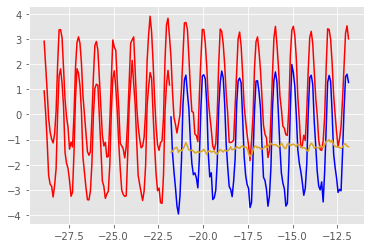

Epoch 4 batch 50 train Loss 0.7044 test Loss 0.6952 with training MSE metric 3.2200 and testing MSE metric 3.2034
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 223.79276728630066 secs

2282


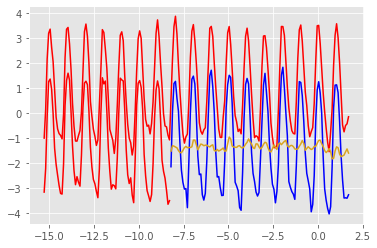

Epoch 5 batch 0 train Loss 0.6955 test Loss 0.6862 with training MSE metric 3.1922 and testing MSE metric 3.1692
learning rate is 0.0003000000142492354
2240


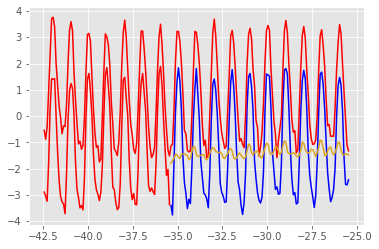

Epoch 5 batch 50 train Loss 0.6797 test Loss 0.6688 with training MSE metric 3.0561 and testing MSE metric 3.0492
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 148.95122408866882 secs

2290


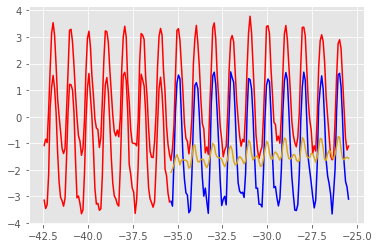

Epoch 6 batch 0 train Loss 0.6609 test Loss 0.6256 with training MSE metric 2.8735 and testing MSE metric 2.7145
learning rate is 0.0003000000142492354
2170


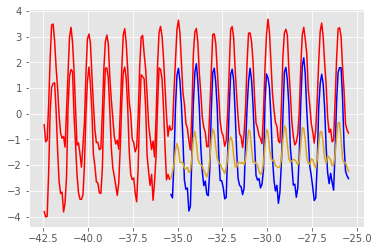

Epoch 6 batch 50 train Loss 0.5937 test Loss 0.5526 with training MSE metric 2.2539 and testing MSE metric 2.0884
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 125.76767206192017 secs

2205


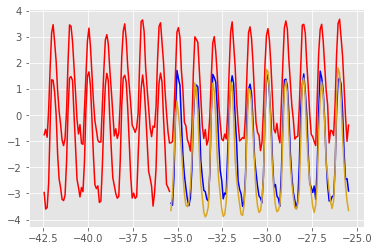

Epoch 7 batch 0 train Loss 0.2119 test Loss 0.2618 with training MSE metric 0.6118 and testing MSE metric 0.8685
learning rate is 0.0003000000142492354
2089


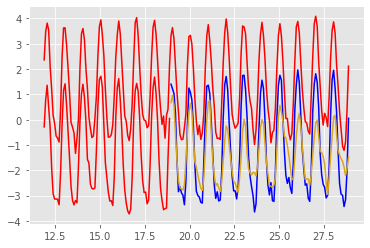

Epoch 7 batch 50 train Loss 0.0563 test Loss -0.0072 with training MSE metric 0.3562 and testing MSE metric 0.2935
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 147.03169107437134 secs

2224


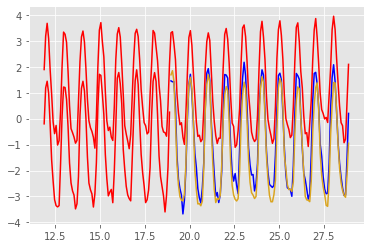

Epoch 8 batch 0 train Loss -0.0753 test Loss -0.0907 with training MSE metric 0.1432 and testing MSE metric 0.1351
learning rate is 0.0003000000142492354
2040


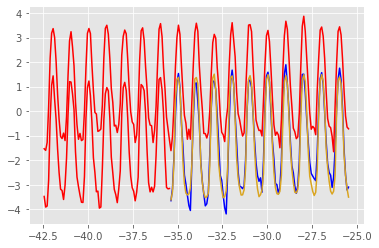

Epoch 8 batch 50 train Loss -0.0915 test Loss -0.0954 with training MSE metric 0.1289 and testing MSE metric 0.1314
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 152.17923402786255 secs

2250


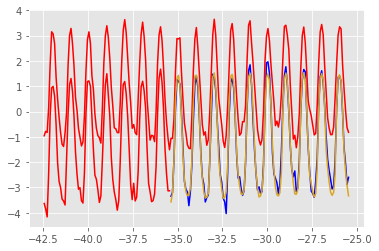

Epoch 9 batch 0 train Loss -0.1109 test Loss -0.1782 with training MSE metric 0.1169 and testing MSE metric 0.0893
learning rate is 0.0003000000142492354
2299


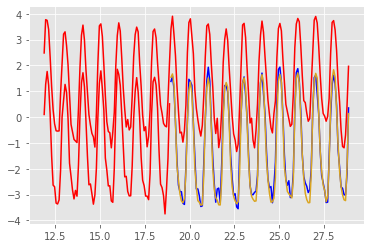

Epoch 9 batch 50 train Loss -0.1560 test Loss -0.1976 with training MSE metric 0.0967 and testing MSE metric 0.0832
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 177.7578089237213 secs

2159


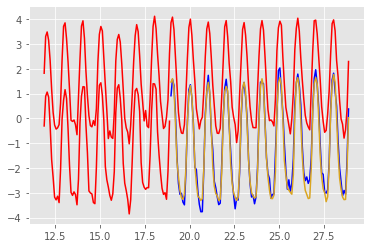

Epoch 10 batch 0 train Loss -0.1465 test Loss -0.2054 with training MSE metric 0.1031 and testing MSE metric 0.0820
learning rate is 0.0003000000142492354
2092


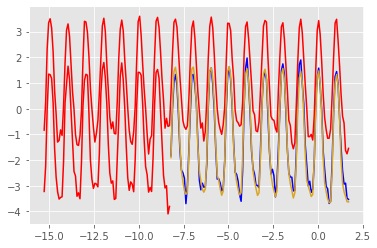

Epoch 10 batch 50 train Loss -0.1556 test Loss -0.2106 with training MSE metric 0.1002 and testing MSE metric 0.0789
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 152.22031116485596 secs

2017


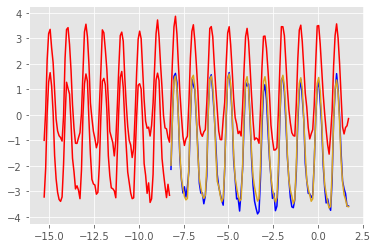

Epoch 11 batch 0 train Loss -0.1728 test Loss -0.2175 with training MSE metric 0.0923 and testing MSE metric 0.0788
learning rate is 0.0003000000142492354
2247


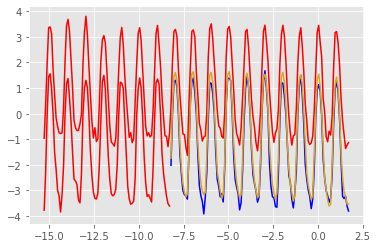

Epoch 11 batch 50 train Loss -0.1834 test Loss -0.2313 with training MSE metric 0.0895 and testing MSE metric 0.0730
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 153.22445011138916 secs

2150


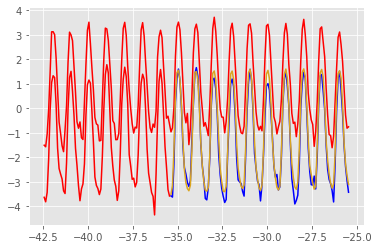

Epoch 12 batch 0 train Loss -0.1966 test Loss -0.2203 with training MSE metric 0.0842 and testing MSE metric 0.0792
learning rate is 0.0003000000142492354
2288


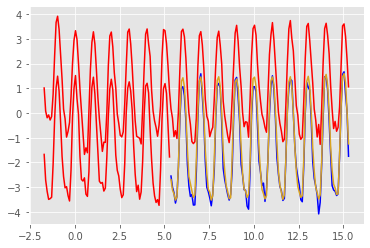

Epoch 12 batch 50 train Loss -0.2004 test Loss -0.2275 with training MSE metric 0.0834 and testing MSE metric 0.0772
learning rate is 0.0003000000142492354


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-78248b2eda79>", line 22, in <module>
    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x_tr, y_tr, d = True, to_gather=temp)
  File "/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 2943, in __call__
    filtered_flat_args, captured_inputs=graph_function.captured_inputs)

KeyboardInterrupt: 

In [72]:
if __name__ == '__main__':
    step = 0
    # change to run 9 if you want to overfit
    EPOCHS = 575; batch_s  = 32; run = 7; tr_regime ='shuffle'
    l= [96, 64, 32]; heads = 32; e = 96; context = 290; c=290
    decoder, optimizer_c, ckpt, manager, num_batches, writer, folder = helpers.pre_trained_loader(data[3], save_dir, e, l, d=d, batch_s=64, context=context, heads=1, run=run)
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()
            for batch_n in range(100):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    idxs = np.random.choice(np.arange(2000), 32)
                    permute_idx = np.arange(410)
                    y_tr = d_y[idxs, :][:, permute_idx] 
                    x_tr = x[idxs, :]
                    to_gather = helpers.gather_idx(c,  l=410, b=32)
                    temp = np.zeros((32, 410))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
#                   b_data, c = batch_creator.batch_regime_2d(x = data[-3], y = data[-1], em = data[2] , em_2 =  data[3], batch_s=64, context_p=50, kind='shuffle')
                    # add parameter b=20 to helpers.gather_idx if you want to overfit and comment line above
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x_tr, y_tr, d = True, to_gather=temp)
                else:
#                     b_data = batch_creator.create_batch(em_x = data[1], x = data[3], y = data[-1], batch_s=64, d=d)
                    to_gather = helpers.gather_idx(context, l=200, b=2)
                    temp = np.zeros((b_data[0].shape[0], b_data[0].shape[1]))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], y2=b_data[3], to_gather = temp)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context, heads)
                if batch_n % 50 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        idxs_te = np.random.choice(np.arange(2000, 2325), 32)
                        print(idxs_te[1])
                        permute_idx_te = np.arange(410)
                        to_gather_te = helpers.gather_idx(c, l=410, b=32)
                        temp_te = np.zeros((32, 410))
                        temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
                        y_te = d_y[idxs_te, :][:, permute_idx_te] 
                        x_te = x[idxs_te, :]
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = x_te, y_te = y_te, to_gather=temp_te, d=True)
                        fig,ax = plt.subplots()
                        
                        ax.plot(t_y[idxs_te[1], 290:], y_te[1][290:], c='blue')
                        ax.plot(t_y[idxs_te[1], :205], y_te[1][:205], c='red')
                        ax.plot(t_y[idxs_te[1], 205:290], y_te[1][205:290], c='red')
                        ax.plot(t_y[idxs_te[1], 290:], pred_te[1, 289:], c='goldenrod') 
                        plt.show()
                        
                        
                        
#                         b_data_te, c_te = batch_creator.batch_regime_2d(x = data[-4], y = data[-2], em = data[0] , em_2 =  data[1], batch_s=64, context_p=context, kind=tr_regime)
#                         to_gather_te = helpers.gather_idx(c_te)
#                         temp_te = np.zeros((b_data_te[0].shape[0], b_data_te[0].shape[1]))
#                         temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
#                         pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=temp_te, d=True)
#                         ## Plotting progress by looking at a random test case. Erase _te from the six lines below if you rather observe training

#                         if to_gather_te is not None:
#                             # change 64 to 20 if you are overfitting
#                             idd = np.random.choice(np.arange(0, 64))
#                             seq_l = to_gather_te[to_gather_te[:, 0] == idd][0, 1]
#                             plt.scatter(b_data_te[1][idd, :seq_l], b_data_te[0][idd, :seq_l] , c = 'blue', label = 'context')
#                             plt.scatter(b_data_te[1][idd, seq_l:], b_data_te[0][idd, seq_l:], c = 'black', label = 'observed func.', alpha=0.5)
#                             plt.scatter(b_data_te[1][idd, seq_l:], pred_te[idd][(seq_l - 1):], label = 'predicted func.')
#                             plt.legend()
#                             plt.show()
#                         else:
#                             plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], em_2_te = b_data_te[3] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], y2_te=b_data_te[3], to_gather = temp)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
#                     if d:
#                         m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
#                         m0_te, m1_te = metrics.r_sq_2d(b_data_te[0][:, 1:], pred_te.numpy(), b_data_te[3][:, 1:], context_p = context)
#                         print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
#                         print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)
            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [139]:
pred_te.shape

TensorShape([32, 409])

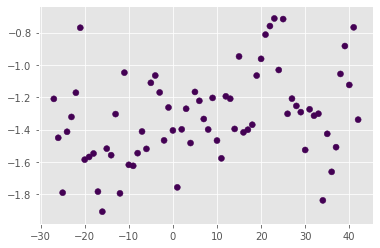

In [299]:
plt.scatter(t[100:], pred_te[1, 99:], c=k[100:]) 

### Embeddings in tensorboard

In [ ]:
helpers.tensorboard_embeddings(decoder, layer_num = 0, meta_data = np.concatenate(([0, 1], np.unique(b_data[2]))))

### Inference

In [39]:
d_y[1, :290].shape

(290,)

In [258]:
x.shape

(2325, 410, 82)

In [ ]:
step = 0
EPOCHS = 3575; batch_s  = 32; run = 7; tr_regime ='shuffle'
l= [96, 64, 32]; heads = 32; e = 96; context = 290; c=290
name_comp = 'run_' + str(run)
logdir = save_dir + '/logs/' + name_comp
writer = tf.summary.create_file_writer(logdir)
folder = save_dir + '/ckpt/check_' + name_comp
optimizer_c = tf.keras.optimizers.Adam(3e-4)
helpers.mkdir(folder)
decoder = experimental2d_model.Decoder(e, l[0], l[1], l[2], num_heads=heads)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer_c, net=decoder)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


idd = np.random.choice(np.arange(325))
fig,ax = plt.subplots()
for j in range(100):
    y_s = d_y[2000 + idd, :290] 
    y_s = y_s[:-1][None, :]
    for i in range(119):
        x_s = x[2000+idd, :(290 + i), :][None, :, :]
        _, _, sample_y = evaluate(decoder, x_s, y_s, d=d, sample=True)
        y_s = tf.concat((y_s, tf.reshape(sample_y, [1, 1])), axis=1)
    ax.plot(t_y[2000+idd, :205], d_y[2000+idd][:205], c='red')
    ax.plot(t_y[2000+idd, 205:290], d_y[2000+idd][205:290], c='red')
    
    ax.plot(t_y[2000+idd, 290:-1], (y_s.numpy()[:, 289:].reshape(-1)), c='lightblue')
y_s = d_y[2000 + idd, :290] 
y_s = y_s[:-1][None, :]
for i in range(119):
    x_s = x[2000+idd, :(290 + i), :][None, :, :]
    _, _, sample_y = evaluate(decoder, x_s, y_s, d=d, sample=False)
    y_s = tf.concat((y_s, tf.reshape(sample_y, [1, 1])), axis=1)
ax.plot(t_y[2000+idd, :205], d_y[2000+idd][:205], c='red')
ax.plot(t_y[2000+idd, 205:290], d_y[2000+idd][205:290], c='red')
ax.plot(t_y[2000+idd, 290:-1], (y_s.numpy()[:, 289:].reshape(-1)), c='goldenrod')
ax.plot(t_y[2000+idd, 290:], d_y[2000+idd][290:], c='blue', alpha = 0.4)

Already exists


Restored from /Users/omernivron/Downloads/monthly_global_avg_climate/ckpt/check_run_7/ckpt-26


In [59]:
def evaluate(model, x, y, sample=True, d=False):

    combined_mask_x = masks.create_masks(x[:, :, 0])
    pred = model(x, y, False, combined_mask_x[:, :-1, :-1])
    if sample:
        sample_y = np.random.normal(pred[-1, 0], np.exp(pred[-1, 1]))
    else:
        sample_y = pred[-1, 0]

    return pred[:, 0], pred[:, 1], sample_y

In [60]:
from helpers import masks